In [39]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import requests

In [40]:
%%capture
%run -i -e main.ipynb

In [41]:
# correlation matrix of Cluster 3 (highest return)
cluster_id = 3  # replace with the actual cluster_id

# Extract tickers for the specified cluster
cluster_tickers = clusters['ticker']

# Filter the DataFrame based on the tickers in the specified cluster
preferred_cluster = data[cluster_tickers]

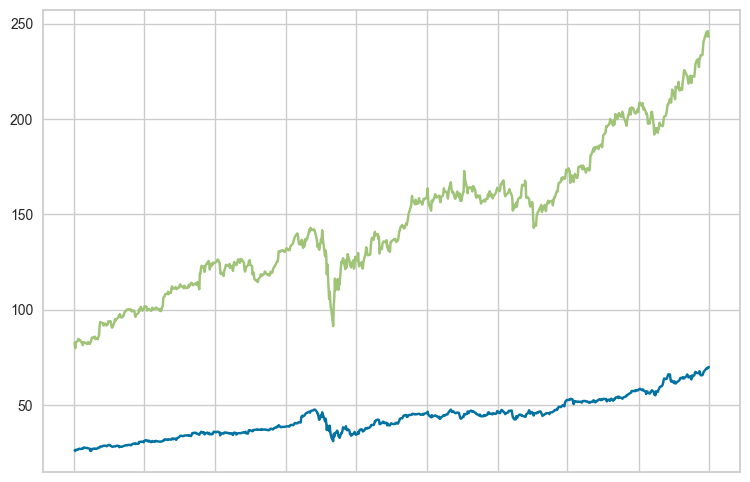

In [69]:
plt.figure(figsize=(9, 6), dpi=100)
stock_1_name = "BRO"
stock_2_name = "ZTS"
stock_1 = preferred_cluster[preferred_cluster.index > '2019-01-01'][stock_1_name]
stock_2 = preferred_cluster[preferred_cluster.index > '2019-01-01'][stock_2_name] 

plt.plot(stock_1, label = stock_1_name)
plt.plot(stock_2, label = stock_2_name)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#plt.xticks([])  # Remove x-axis ticks
#plt.legend()
#plt.savefig('Pair_Trade_intro.svg',format='svg', bbox_inches='tight')
plt.show()


In [70]:
preferred_cluster

,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.305023,51.647560,41.075401,79.550964,54.646271,144.274887,177.699997,82.765312,35.165939,105.598396,...,154.734451,42.066658,66.545746,64.630898,64.491646,75.387535,116.359734,103.709999,44.894779,69.868118
2018-01-03,66.966637,51.014027,41.068260,80.795830,54.767101,144.940720,181.039993,83.792084,34.894012,106.745522,...,153.058075,41.785095,67.852715,64.409477,65.278023,75.322861,117.166344,105.769997,44.841648,70.189369
2018-01-04,66.464294,51.335659,41.259010,80.335068,54.674156,146.656967,183.220001,83.700409,35.481724,107.765190,...,153.886810,41.459538,67.946640,64.399857,65.713814,76.089676,116.997498,107.860001,45.027615,70.607986
2018-01-05,67.526939,51.316170,41.728756,81.733505,54.832184,147.866745,185.339996,84.039627,35.244881,107.701454,...,154.913391,41.169186,67.891838,65.304726,65.590652,76.533119,118.160545,109.540001,45.045311,71.415993
2018-01-08,67.671867,50.809345,41.573761,80.423965,54.674156,149.048401,185.039993,84.186310,35.165939,107.373703,...,152.850906,41.477135,68.197075,65.747551,65.827507,76.662468,118.385658,110.629997,44.823944,72.272667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,158.002838,18.170000,179.836319,131.908493,140.403183,413.026154,577.679993,173.808624,65.419395,243.909973,...,87.580002,65.883125,60.590763,55.504356,117.468552,136.694839,123.570305,606.330017,62.253880,245.684570
2021-12-28,158.440781,18.540001,178.799164,131.888855,139.420593,412.966461,569.359985,172.728943,66.270920,243.692108,...,86.459999,66.671913,60.394962,55.583714,118.690010,136.665131,123.957039,597.320007,62.352680,243.432159
2021-12-29,159.903946,18.049999,178.888916,132.840790,140.135193,413.115692,569.289978,173.858154,66.350136,245.613358,...,84.980003,67.007141,59.866302,56.198784,118.531120,137.338654,123.976379,601.119995,62.688602,246.202850


Null Hypothesis: Spread between series are non-stationary. 
Uses the augmented Engle-Granger two-step cointegration test. 
If p_val < 0.05 that's meaning existing cointegration

In [71]:

coint = ts.coint(stock_1, stock_2)
cointegration_t_statistic = coint[0]
p_val = coint[1]
critical_values_test_statistic_at_1_5_10 = coint[2]
p_val

0.003181011488256339

Compute the ADF test. With all time series, you want to have stationary data otherwise our data will be very hard to predict.

In [72]:
stock_1_ADF = adfuller(stock_1)
print('P value for the Augmented Dickey-Fuller Test is', stock_1_ADF[1])

stock_2_ADF = adfuller(stock_2)
print('P value for the Augmented Dickey-Fuller Test is', stock_2_ADF[1])

Spread_ADF = adfuller(stock_1 - stock_2)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])

Ratio_ADF = adfuller(stock_1 / stock_2)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])
# That means, only one time series is cointegrated, this is spread

P value for the Augmented Dickey-Fuller Test is 0.9791950613887063
P value for the Augmented Dickey-Fuller Test is 0.9870910342158136
P value for the Augmented Dickey-Fuller Test is 0.96398281234838
P value for the Augmented Dickey-Fuller Test is 0.0010920433824682277


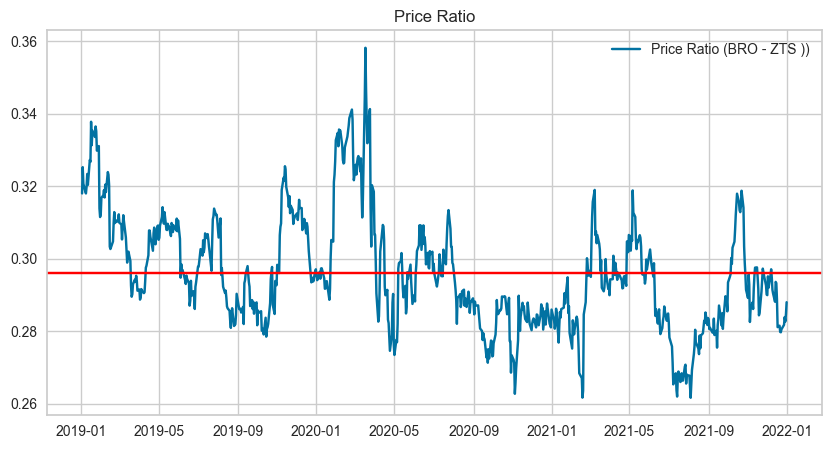

In [73]:
plt.figure(figsize=(10, 5))
ratio = stock_1/stock_2
plt.plot(ratio, label = f'Price Ratio ({stock_1_name} - {stock_2_name} ))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio")
plt.show()

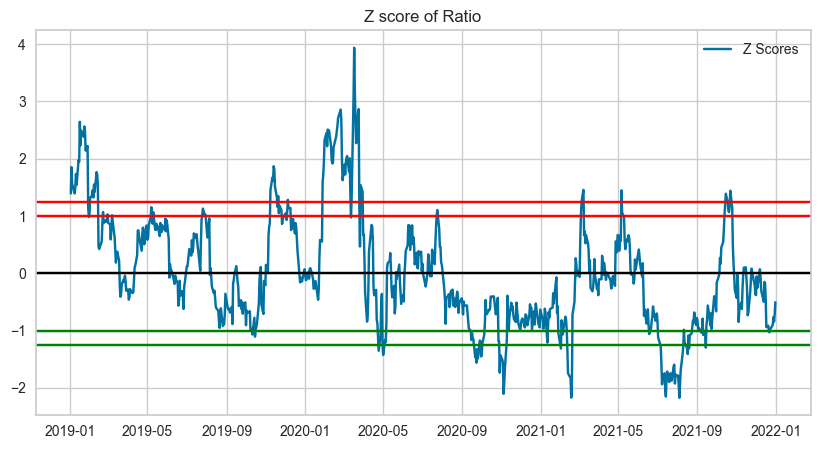

In [74]:
plt.figure(figsize=(10, 5))
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio')
plt.show()

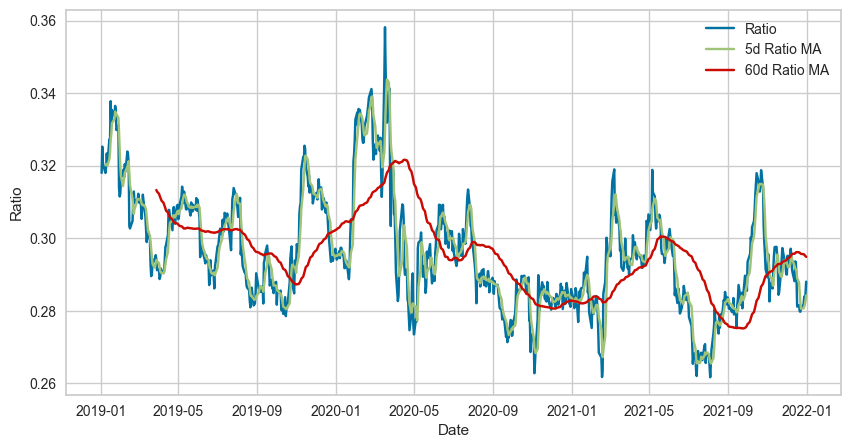

In [75]:
plt.figure(figsize=(10, 5))
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

std_60 = ratio.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

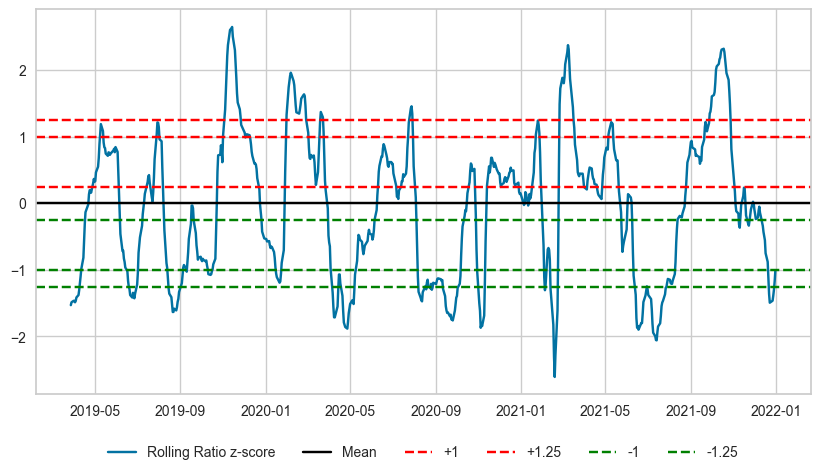

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(zscore_60_5)
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.axhline(0.25, color='red', linestyle='--')
plt.axhline(-0.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
plt.show()

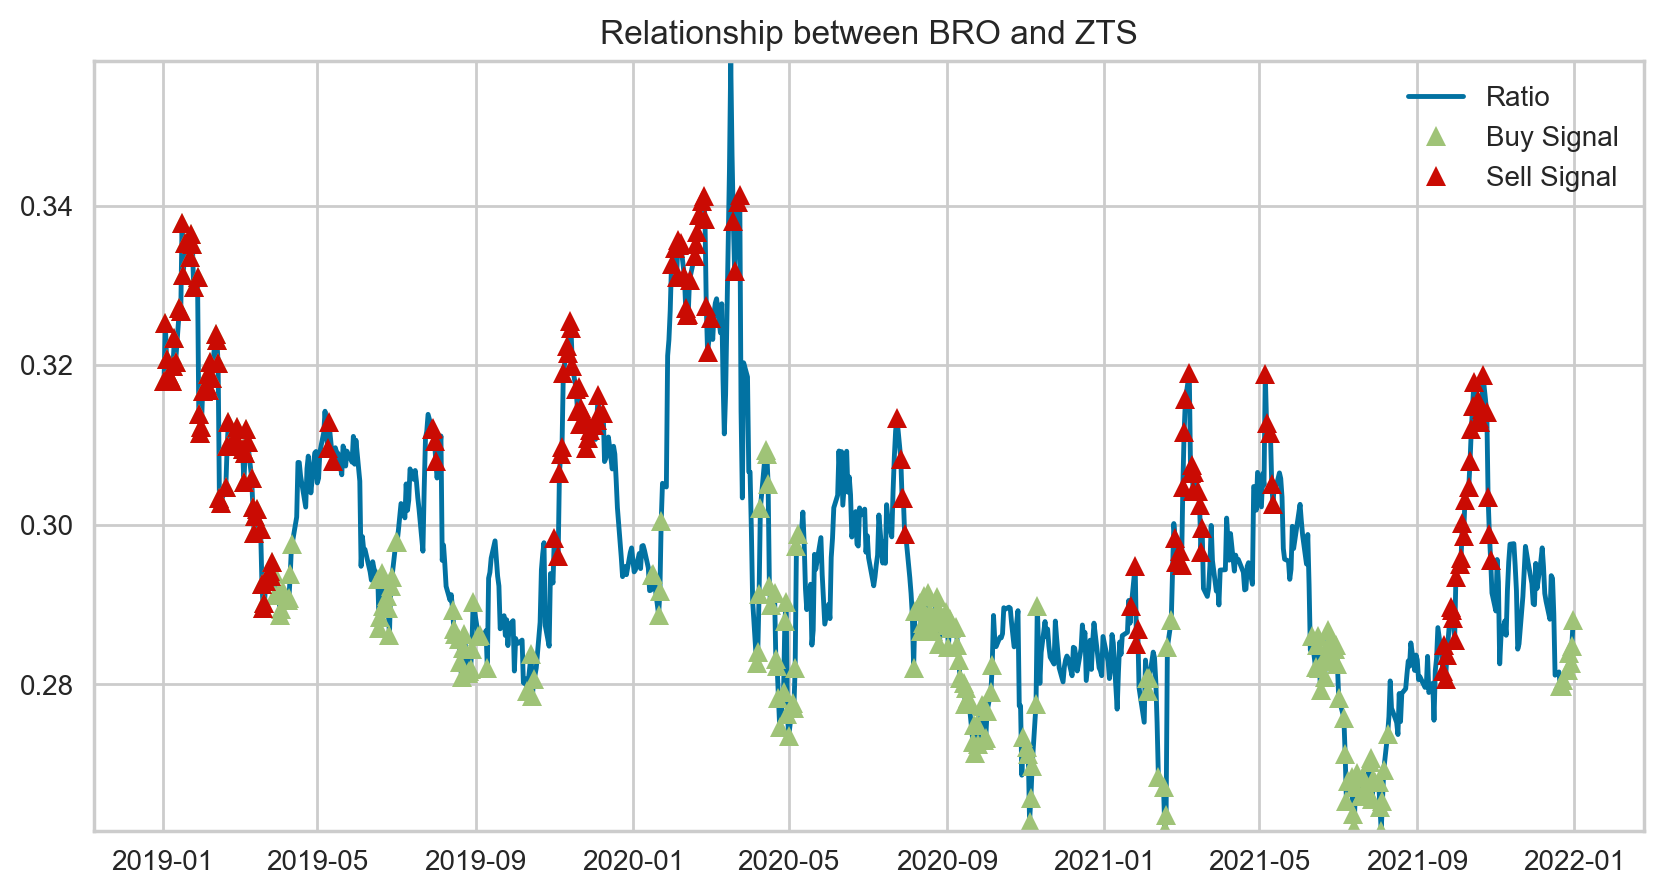

In [77]:
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(ratio)
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_60_5 > -1] = np.nan
sell[zscore_60_5 < 1] = np.nan
plt.plot(buy, color='g', linestyle='None', marker='^')
plt.plot(sell, color='r', linestyle='None', marker='^')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title(f'Relationship between {stock_1_name} and {stock_2_name}')
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
plt.show()

In [51]:
preferred_cluster

,A,AAL,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADM,ADP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.305023,51.647560,41.075401,79.550964,54.646271,144.274887,177.699997,82.765312,35.165939,105.598396,...,154.734451,42.066658,66.545746,64.630898,64.491646,75.387535,116.359734,103.709999,44.894779,69.868118
2018-01-03,66.966637,51.014027,41.068260,80.795830,54.767101,144.940720,181.039993,83.792084,34.894012,106.745522,...,153.058075,41.785095,67.852715,64.409477,65.278023,75.322861,117.166344,105.769997,44.841648,70.189369
2018-01-04,66.464294,51.335659,41.259010,80.335068,54.674156,146.656967,183.220001,83.700409,35.481724,107.765190,...,153.886810,41.459538,67.946640,64.399857,65.713814,76.089676,116.997498,107.860001,45.027615,70.607986
2018-01-05,67.526939,51.316170,41.728756,81.733505,54.832184,147.866745,185.339996,84.039627,35.244881,107.701454,...,154.913391,41.169186,67.891838,65.304726,65.590652,76.533119,118.160545,109.540001,45.045311,71.415993
2018-01-08,67.671867,50.809345,41.573761,80.423965,54.674156,149.048401,185.039993,84.186310,35.165939,107.373703,...,152.850906,41.477135,68.197075,65.747551,65.827507,76.662468,118.385658,110.629997,44.823944,72.272667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,158.002838,18.170000,179.836319,131.908493,140.403183,413.026154,577.679993,173.808624,65.419395,243.909973,...,87.580002,65.883125,60.590763,55.504356,117.468552,136.694839,123.570305,606.330017,62.253880,245.684570
2021-12-28,158.440781,18.540001,178.799164,131.888855,139.420593,412.966461,569.359985,172.728943,66.270920,243.692108,...,86.459999,66.671913,60.394962,55.583714,118.690010,136.665131,123.957039,597.320007,62.352680,243.432159
2021-12-29,159.903946,18.049999,178.888916,132.840790,140.135193,413.115692,569.289978,173.858154,66.350136,245.613358,...,84.980003,67.007141,59.866302,56.198784,118.531120,137.338654,123.976379,601.119995,62.688602,246.202850


In [52]:
corr = preferred_cluster.corr()
pairs_list = set()

for pair in combinations(cluster_tickers, 2):
    stock1, stock2 = pair
    correlation = abs(corr[stock1][stock2])
    
    if correlation > 0.9 and correlation != 1:
        coint = sm.tsa.coint(preferred_cluster[stock1], preferred_cluster[stock2])
        
        # Check if the cointegration test is significant
        if coint[1] < 0.01:
            pairs_list.add((stock1, stock2, correlation,1-coint[1]))

sorted_pairs_list = sorted(pairs_list, key=lambda x: x[3]*x[2], reverse=True)

# Take the top 10 pairs with the highest correlation
top_10_pairs = sorted_pairs_list[:10]

# Print or use the top 10 pairs
print("Top 10 pairs with highest correlation and cointegration:")
for pair in top_10_pairs:
    print(pair)


KeyboardInterrupt: 

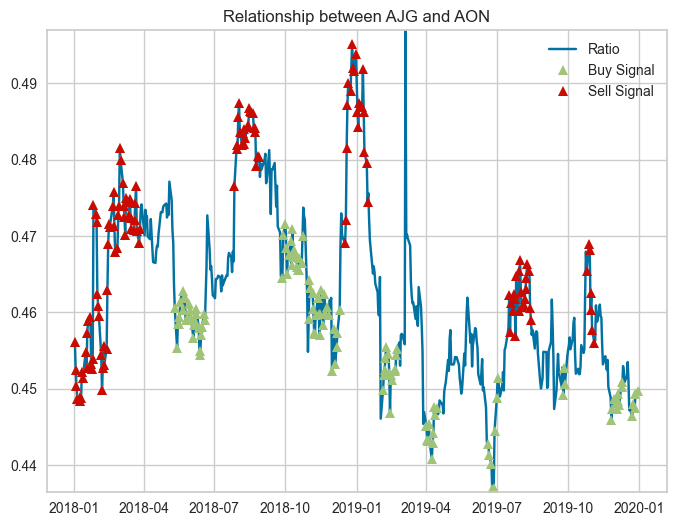

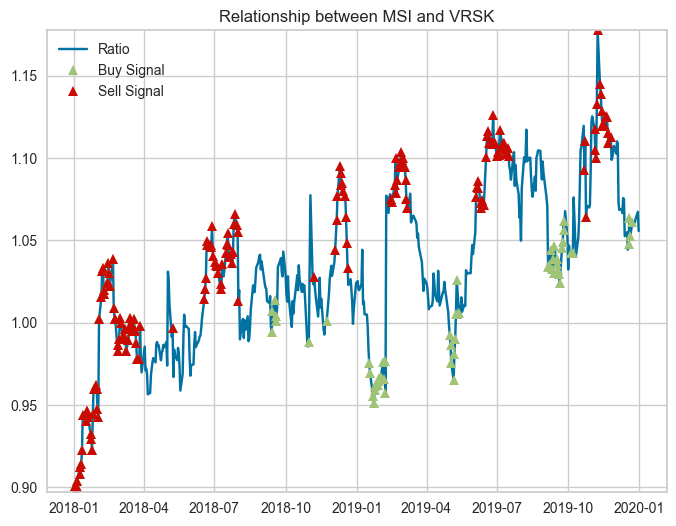

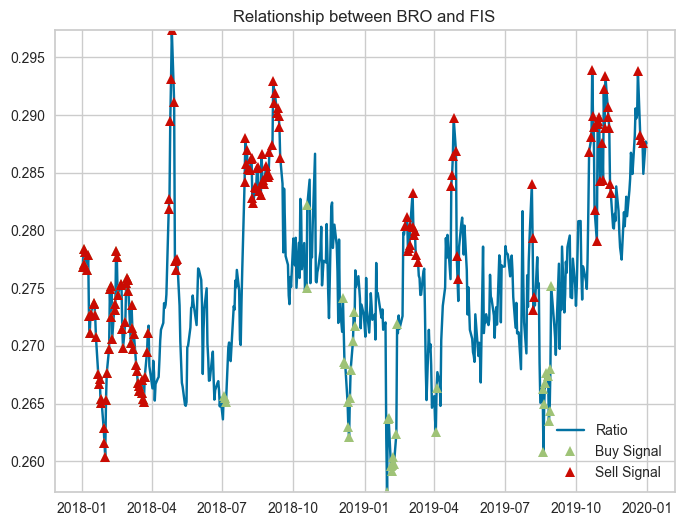

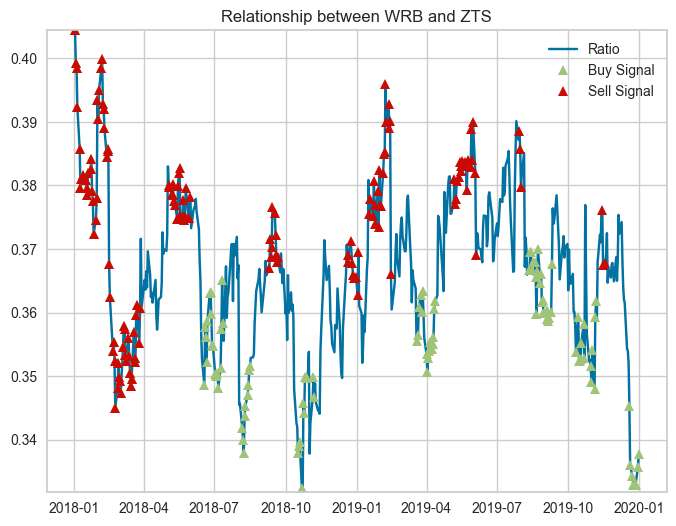

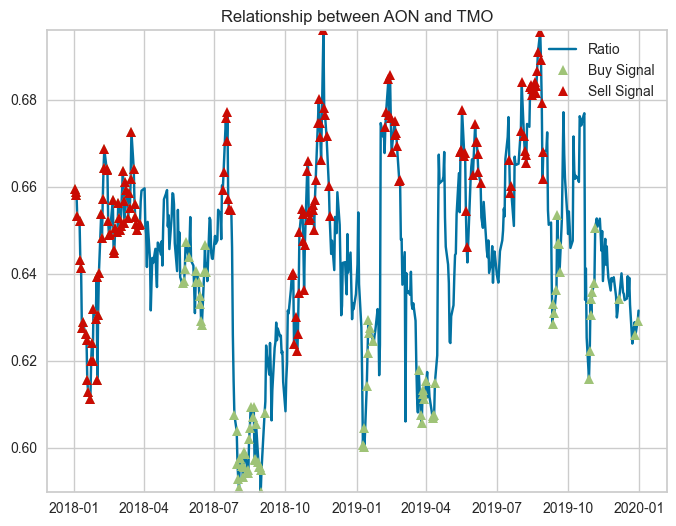

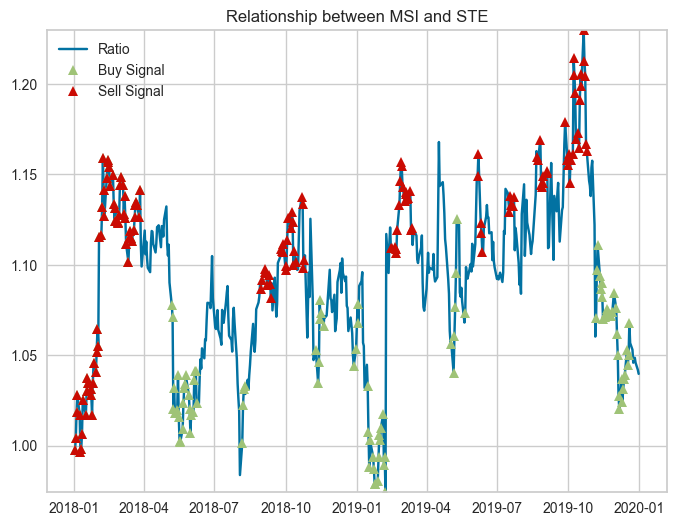

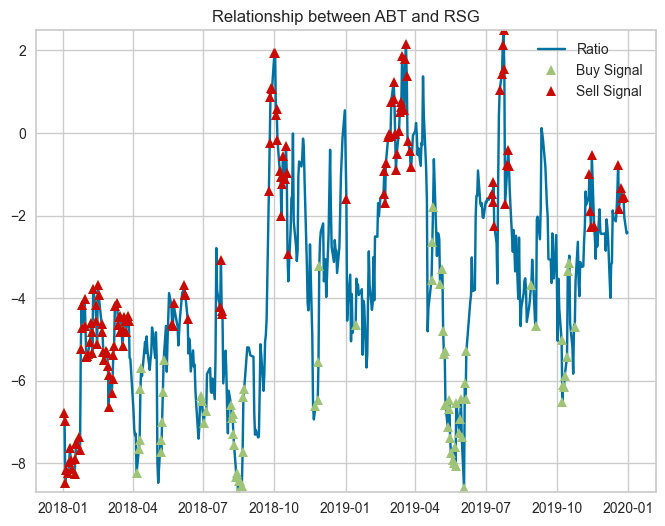

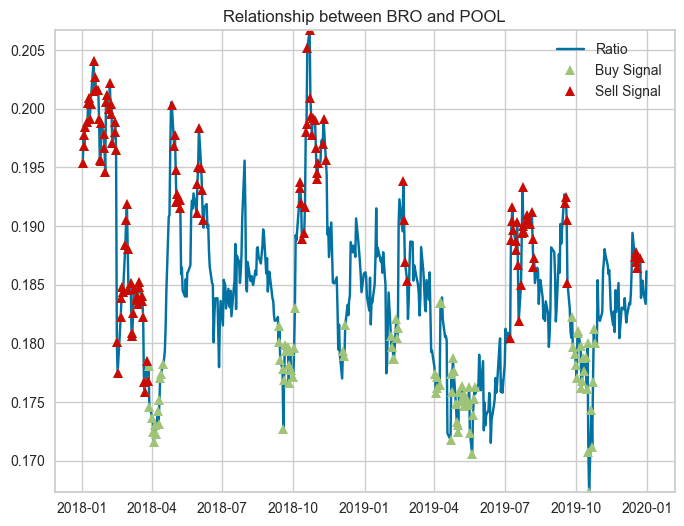

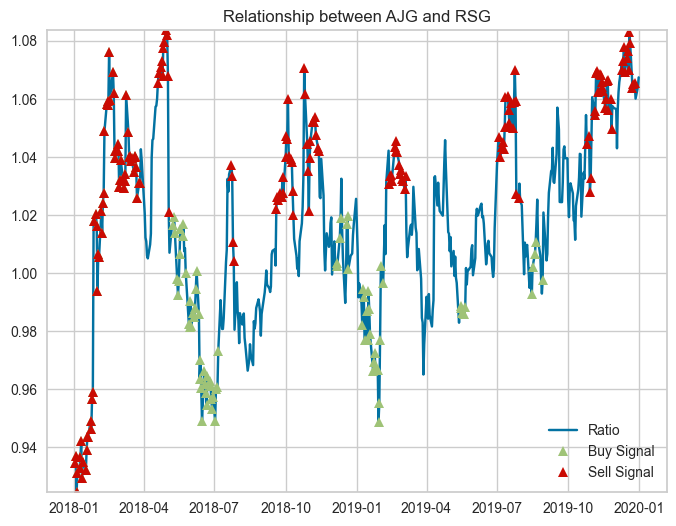

In [ ]:
for pair in top_10_pairs:
    # Cointgration test
    stock_1 = preferred_cluster[pair[0]]
    stock_2 = preferred_cluster[pair[1]]
    result = ts.coint(stock_1, stock_2)
    
    cointegration_t_statistic = result[0]
    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        first_ADF = adfuller(stock_1)
        second_ADF = adfuller(stock_2)
        Spread_ADF = adfuller(stock_1 - stock_2)
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

            plt.figure(figsize=(8, 6), dpi=100)
            plt.plot(ratio)
            buy = ratio.copy()
            sell = ratio.copy()
            buy[zscore_60_5>-1] = np.nan
            sell[zscore_60_5<1] = np.nan

            plt.plot(buy, color='g', linestyle='None', marker='^')
            plt.plot(sell, color='r', linestyle='None', marker='^')

            x1, x2, y1, y2 = plt.axis()
            plt.axis((x1, x2, ratio.min(), ratio.max()))
            plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
            plt.title(f'Relationship between {pair[0]} and {pair[1]}')
            plt.show()